In [2]:
import matplotlib as plt
import textwrap

In [3]:
plt.rcParams['font.family']='Roboto'
plt.rcParams['font.size']=9

In [4]:
import sys
sys.path.append('..')
from utils import *

In [5]:
# arxiv_number_list=['1106.6060','1812.04213','2004.04168','2008.08998','2012.04554','2108.02159','2110.11330','2111.01152','2112.07523',]
arxiv_number_list = [
    "1010.1819",
    "1106.6060",
    "1208.0116",
    # "1212.5363", # TODO
    "1310.2674",
    "1508.00296",
    "1812.04213",
    "2004.04168",
    "2008.08998",
    "2012.04554",
    "2108.02159",
    "2110.11330",
    "2111.01152",
    "2112.07523",
    "2308.03843",
    "2308.07488",
]
# '2308.03843'

In [6]:
len(set(arxiv_number_list))

15

In [7]:
import pandas as pd

In [8]:
def load_arxiv(arxiv_number):
    # Load arxiv and convert to dict
    prompt_template='../prompt_template.md'
    prompt_dict=load_prompt_template(prompt_template)
    with open(os.path.join('..',f'{arxiv_number}',f'{arxiv_number}.yaml'),'r') as f:
        kwargs= yaml.safe_load(f)
    # tasks = [f'Task:{idx+1} '+kwarg['task'] for idx,kwarg in enumerate(kwargs[1:])]
    tasks = [kwarg['task'] for idx,kwarg in enumerate(kwargs[1:])]
    score_dict={}
    for kwarg in kwargs[1:]:
        for key,value in (list(kwarg['score'].items())):
            assert isinstance(value, int), f'{arxiv_number}/{kwarg["task"]}:{key}:{value} is not int'
            if key not in score_dict:
                score_dict[key]=[value]
            else:
                score_dict[key].append(value)
    
    return pd.DataFrame(score_dict,index=tasks)

In [9]:
arxiv_dict_list={arxiv_number:load_arxiv(arxiv_number) for arxiv_number in arxiv_number_list}
execution=pd.concat(arxiv_dict_list.values(),keys=arxiv_dict_list.keys(),names=['arxiv_number','task'])

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def plot_single_file(score_dict):
    x = np.arange(len(score_dict['task']))  # the label locations
    width = 0.15  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained',figsize=(8,5))
    color_list=[plt.cm.Blues(0.2+0.8*(i/6)) for i in range(6,0,-1)]
    for attribute, measurement in score_dict['score'].items():
        offset = width * multiplier
        rects = ax.barh(x + offset, np.array(measurement)+0.1, width, label=attribute,color=color_list[multiplier],left=-0.1)
        # ax.bar_label(rects, padding=3)
        multiplier += 1

    ax.set_xlabel('Score')
    ax.set_xticks([0,1,2])
    ax.set_title(f"{score_dict['arxiv']} [mean={np.mean(score_dict['score']['final answer accuracy']):.2f}]")
    ax.set_yticks(x + width*4, ['\n'.join(textwrap.wrap(task, width=40)) for task in score_dict['task']],fontsize=8)

    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles[::-1], labels[::-1],loc='upper left', ncols=1,bbox_to_anchor=(1, 1))

    ax.grid(axis='x',ls='--')
    # ax.set_ylim(0, 250)
    ax.set_xlim(-0.1,2.1)


In [11]:
color_list=[plt.cm.Blues(0.2+0.8*(i/6)) for i in range(6,0,-1)]

In [12]:
def plot_single_file(arxiv_df,arxiv_number):
    # arxiv_df=arxiv_dict_list['1010.1819']
    ax=arxiv_df.plot(kind='barh',figsize=(8,5),width=0.8,color=color_list,edgecolor='black')
    ax.grid(axis='x',ls='--')
    ax.set_ylabel('')
    ax.set_xlabel('Score')
    # ax.set_yticklabels(['\n'.join(textwrap.wrap(task, width=20)) for task in data_groupby_branch['Score']['mean'].sort_values().index],fontsize=7)
    ax.set_yticklabels(['\n'.join(textwrap.wrap(task, width=40)) for task in arxiv_df.index])
    ax.set_title(f"{arxiv_number}")

In [12]:
# for key,arxiv_df in arxiv_dict_list.items():
#     plot_single_file(arxiv_df,key)

# Score by arxiv , compare with reading

In [13]:
angle_name={'follow_instructions':'adherence','physics_logic':'knowledge','math_derivation':'rigor','final_answer_accuracy':'correctness'}

In [14]:
new_col={key:angle_name[key] if key in angle_name else key.replace('_',' ') for key in execution.columns}

In [15]:
new_col

{'in_paper': 'in paper',
 'prompt_quality': 'prompt quality',
 'follow_instructions': 'adherence',
 'physics_logic': 'knowledge',
 'math_derivation': 'rigor',
 'final_answer_accuracy': 'correctness'}

In [16]:
execution=execution.rename(columns=new_col)

In [17]:
execution_groupby_arxiv=execution.groupby('arxiv_number').agg(['mean','sem','count'])

In [18]:
execution_groupby_arxiv[['correctness']]

correctness                
                    mean       sem count
arxiv_number                            
1010.1819       1.333333  0.256235    12
1106.6060       1.555556  0.175682     9
1208.0116       1.727273  0.194978    11
1310.2674       1.818182  0.121967    11
1508.00296      1.222222  0.222222     9
1812.04213      1.333333  0.224733    12
2004.04168      1.727273  0.140836    11
2008.08998      1.909091  0.090909    11
2012.04554      2.000000  0.000000    11
2108.02159      1.916667  0.083333    12
2110.11330      1.636364  0.203279    11
2111.01152      1.750000  0.111803    16
2112.07523      1.300000  0.260342    10
2308.03843      1.909091  0.090909    11
2308.07488      1.750000  0.130558    12

In [19]:
import pickle

In [20]:
with open('reading_data.pickle','rb') as f:
    reading_data=pickle.load(f)

In [21]:
reading_groupby_arxiv=reading_data.groupby('arxiv').agg(['mean','sem','count'])

In [22]:
reading_groupby_arxiv

Score                
                mean       sem count
arxiv                               
1010.1819   1.181034  0.080849   116
1106.6060   0.770833  0.133951    48
1208.0116   1.446429  0.080057   112
1310.2674   1.111111  0.090680    99
1508.00296  0.937500  0.127740    48
1812.04213  1.194915  0.087837   118
2004.04168  0.708333  0.109125    72
2008.08998  1.595745  0.081900    94
2012.04554  1.058140  0.101095    86
2108.02159  1.155738  0.085550   122
2110.11330  1.181818  0.099036    88
2111.01152  1.601190  0.054809   168
2112.07523  1.693878  0.068662    98
2308.03843  1.350000  0.088048   100
2308.07488  1.140845  0.080944   142

In [23]:
execution_reading=pd.concat([execution_groupby_arxiv[['correctness']],reading_groupby_arxiv],axis=1,).rename(columns={'correctness':'Execution','Score':'Extraction'})

In [24]:
execution_reading

Execution                 Extraction                
                mean       sem count       mean       sem count
1010.1819   1.333333  0.256235    12   1.181034  0.080849   116
1106.6060   1.555556  0.175682     9   0.770833  0.133951    48
1208.0116   1.727273  0.194978    11   1.446429  0.080057   112
1310.2674   1.818182  0.121967    11   1.111111  0.090680    99
1508.00296  1.222222  0.222222     9   0.937500  0.127740    48
1812.04213  1.333333  0.224733    12   1.194915  0.087837   118
2004.04168  1.727273  0.140836    11   0.708333  0.109125    72
2008.08998  1.909091  0.090909    11   1.595745  0.081900    94
2012.04554  2.000000  0.000000    11   1.058140  0.101095    86
2108.02159  1.916667  0.083333    12   1.155738  0.085550   122
2110.11330  1.636364  0.203279    11   1.181818  0.099036    88
2111.01152  1.750000  0.111803    16   1.601190  0.054809   168
2112.07523  1.300000  0.260342    10   1.693878  0.068662    98
2308.03843  1.909091  0.090909    11   1.350000  0.088048   100
2308.07488  1.750000  0.130558    12   1.140845  0.080944   142

In [25]:
execution_reading.corr().loc[("Extraction","mean"),("Execution","mean")]

0.06505089444821313

Text(0.5, 1.0, 'Correlation:0.0651')

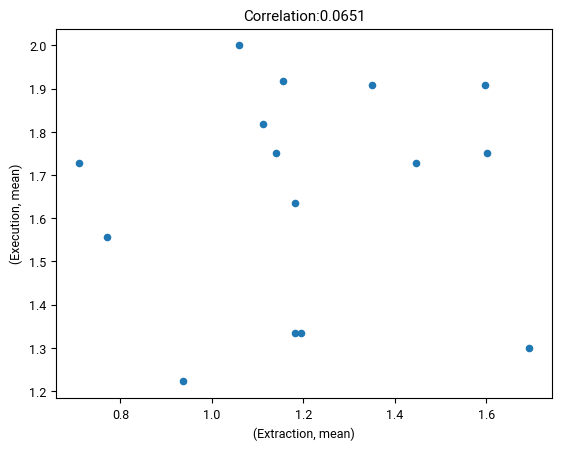

In [26]:
execution_reading.plot(kind='scatter',x=('Extraction','mean'),y=('Execution','mean'))
plt.title(f'Correlation:{execution_reading.corr().loc[("Extraction","mean"),("Execution","mean")]:0.04f}')

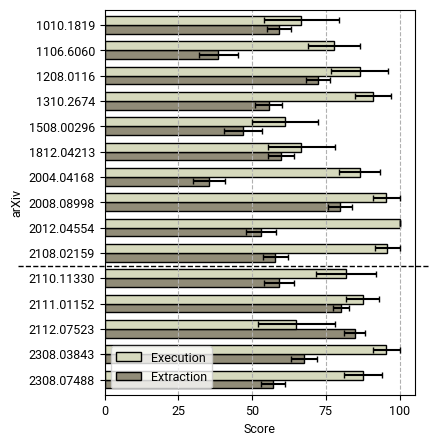

In [28]:
# means = execution_reading.sort_values(by=('Execution','mean'))[[ ("Extraction", "mean"),("Execution", "mean")]].droplevel(1,axis=1)
means = execution_reading[[ ("Extraction", "mean"),("Execution", "mean")]].droplevel(1,axis=1)[::-1]
# errors = execution_reading.sort_values(by=('Execution','mean'))[[("Extraction", "sem"),("Execution", "sem")]].droplevel(1,axis=1)
errors = execution_reading[[("Extraction", "sem"),("Execution", "sem")]].droplevel(1,axis=1)[::-1]
ax = means.plot(kind='barh', xerr=errors, capsize=2,figsize=(4,5),color=['#918c78','#d6d9bd'],edgecolor='k',width=0.7)
ax.grid(axis='x',ls='--')
ax.set_xlabel('Score')
# ax.set_title('\n'.join([f'Mean of {kind}: {mean:.2f} $\pm$ {se:.2f}' for kind,mean,se in zip(['Execution','Extraction',],means.mean()[::-1],errors.mean()[::-1])]))
ax.set_ylabel('arXiv',)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1])
ax.axhline(y=4.5, color='k', linestyle='--',linewidth=1,xmin=-0.28,xmax=1.05,clip_on=False)
ax.set_xticks(ticks=np.arange(0,2.1,0.5),labels=['0','25','50','75','100'])
ax.get_figure().savefig('4b.pdf',bbox_inches='tight')

# Score by aspect

In [29]:
execution.mean().iloc[2:]

adherence      1.786982
knowledge      1.786982
rigor          1.917160
correctness    1.668639
dtype: float64

In [30]:
execution.mean().iloc[2:].index

Index(['adherence', 'knowledge', 'rigor', 'correctness'], dtype='object')

In [31]:
['\n'.join(textwrap.wrap(task.replace(' ',' '), width=20)) for task in execution.mean().iloc[2:].index]

['adherence', 'knowledge', 'rigor', 'correctness']

In [32]:
execution.mean()[2:]

adherence      1.786982
knowledge      1.786982
rigor          1.917160
correctness    1.668639
dtype: float64

In [33]:
execution.sem()[:1:-1]

correctness    0.044980
rigor          0.022862
knowledge      0.036743
adherence      0.039515
dtype: float64

In [ ]:
"ffebd9","fcdddd","f1f5d2","daf1fa"
"#daf1fa","#f1f5d2","#fcdddd","#ffebd9"

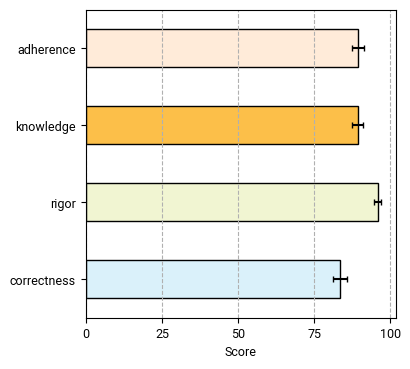

In [65]:
ax=execution.mean().iloc[:1:-1].plot(kind='barh',xerr=execution.sem()[:1:-1],capsize=2,edgecolor='k',figsize=(4,4),color=["#daf1fa","#f1f5d2","#fcbf49","#ffebd9"])
# '#AA5454','#007895','#55571F','#C37B3B'
ax.grid(axis='x',ls='--')
ax.set_xlabel('Score')
ax.set_ylabel('')
# ax.set_yticklabels(['\n'.join(textwrap.wrap(task.replace(' ',' '), width=20)) for task in execution.mean().iloc[:1:-1].index],fontsize=8)
# ax.set_title('Performance of execution from different aspects')

ax.set_xticks(ticks=np.arange(0,2.1,0.5),labels=['0','25','50','75','100'])
ax.get_figure().savefig('3b.pdf',bbox_inches='tight')

# Score by task

In [35]:
# execution[(execution['execution']==2) & (execution.iloc[:,2:-1].mean(axis=1)!=2)]

In [36]:
execution_groupby_task=execution.groupby('task').agg(['mean','sem','count'])

In [37]:
with open('../Naming.yaml','r') as f:
    naming=yaml.safe_load(f)

In [38]:
naming_order=[key for key,val in (naming.items()) if key in execution_groupby_task.index][::-1]

In [39]:
execution_groupby_task_mean=execution_groupby_task[execution_groupby_task[('in paper','count')]>0].loc[naming_order,(slice(None),'mean')].iloc[:,2:].droplevel(1,axis=1)
# .sort_values(by=('correctness','mean'))
execution_groupby_task_sem=execution_groupby_task[execution_groupby_task[('in paper','count')]>0].loc[naming_order,(slice(None),'sem')].iloc[:,2:].droplevel(1,axis=1)
# .sort_values(by=('correctness','mean'))

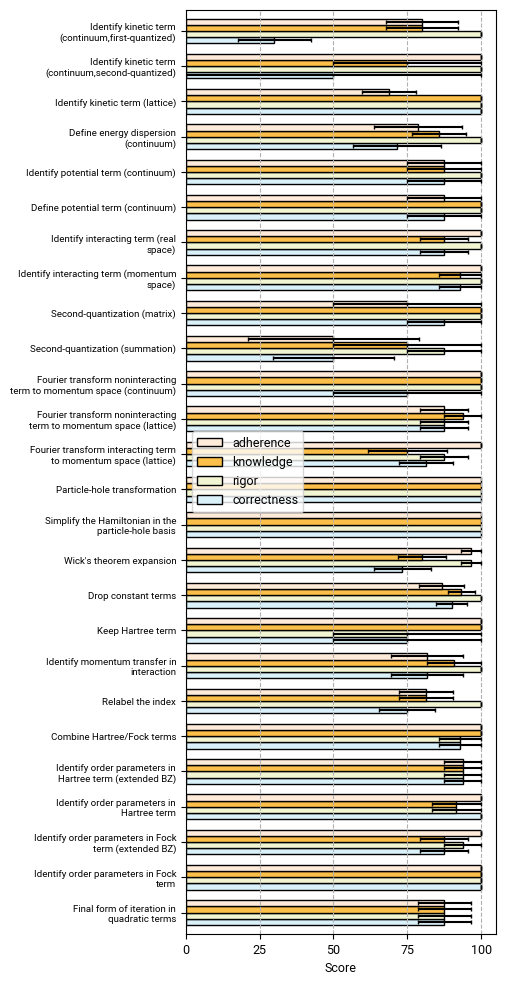

In [67]:
ax=execution_groupby_task_mean.iloc[:,::-1].plot(kind='barh',xerr=execution_groupby_task_sem.iloc[:,::-1],figsize=(4,12),color=["#daf1fa","#f1f5d2","#fcbf49","#ffebd9"],capsize=1.5,edgecolor='k',width=0.7,)
# ['#AA5454','#007895','#55571F','#C37B3B',]
# ['#e7ecef','#274c77','#6096ba','#a3cef1']
ax.grid(axis='x',ls='--')
ax.set_ylabel('')
ax.set_xlabel('Score')
ax.set_yticklabels(['\n'.join(textwrap.wrap(naming[task], width=35)) for task in execution_groupby_task_mean.iloc[:,::-1].index],fontsize=7)
# ax.set_title('Score of execution by tasks')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1])
ax.set_xticks(ticks=np.arange(0,2.1,0.5),labels=['0','25','50','75','100'])

ax.get_figure().savefig('SM_a.pdf',bbox_inches='tight')

# Score by task type

In [40]:
with open('../Task_type.yaml','r') as f:
    task_type=yaml.safe_load(f)

In [41]:
task_type_order=[r'$H=H_0+H_{\rm{int}}$','FT',"Wick's theorem",r'$H_{\rm{HF}}$','OP']
# step_color_list=['#a2d2ff','#bde0fe','#ffafcc','#ffc8dd','#cdb4db']
step_color_list=['#e9dfb3','#bbcdd1','#f3b1b1','#ccda8d','#facfa8']

In [42]:
execution.index=pd.MultiIndex.from_tuples([(index[0],task_type[index[1]],index[1]) for index in execution.index.tolist()],names=['arxiv_number','task_type','task'])

In [43]:
execution_groupby_task_type=execution.groupby('task_type').agg(['mean','sem','count'])
# data_groupby_task=data_groupby_task.loc[task_type_order[::-1]]

In [44]:
execution_groupby_task_type_mean_score=execution.iloc[:,2:].mean(axis=1).groupby('task_type').agg(['mean','sem','count'])

In [45]:
execution_groupby_task_type_mean_score

,mean,sem,count
task_type,,,
$H=H_0+H_{\rm{int}}$,1.783333,0.045366,45
$H_{\rm{HF}}$,1.785714,0.068904,28
FT,1.723214,0.073124,28
OP,1.848684,0.060771,38
Wick's theorem,1.791667,0.062380,30


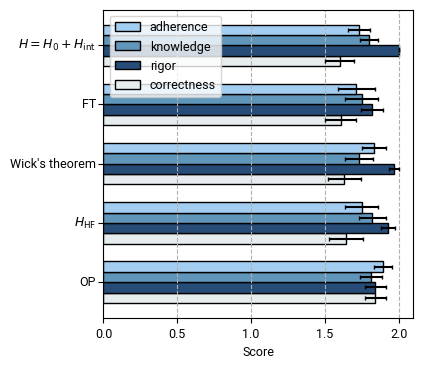

In [51]:
execution_groupby_task_type_mean=execution_groupby_task_type[execution_groupby_task_type[('in paper','count')]>2].loc[task_type_order[::-1]].loc[:,(slice(None),'mean')].iloc[:,:1:-1].droplevel(1,axis=1)
execution_groupby_task_type_sem=execution_groupby_task_type[execution_groupby_task_type[('in paper','count')]>2].loc[task_type_order[::-1]].loc[:,(slice(None),'sem')].iloc[:,:1:-1].droplevel(1,axis=1)
ax=execution_groupby_task_type_mean.plot(kind='barh',xerr=execution_groupby_task_type_sem,figsize=(4,4),color=['#e7ecef','#274c77','#6096ba','#a3cef1'],capsize=1.5,edgecolor='k',width=0.7,)
ax.grid(axis='x',ls='--')
ax.set_ylabel('')
ax.set_xlabel('Score')
# ax.set_yticklabels(['\n'.join(textwrap.wrap(task, width=20)) for task in execution_groupby_task_type_mean.index],fontsize=7)
ax.set_yticklabels([])
[ax.text(-0.05,idx,task,ha='right',va='center',) for (idx,task) in (enumerate(execution_groupby_task_type_mean.index))]
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1])
# ax.set_title('Score of execution by different steps')

In [46]:
execution_groupby_task_type_mean_score.loc[task_type_order]

,mean,sem,count
task_type,,,
$H=H_0+H_{\rm{int}}$,1.783333,0.045366,45
FT,1.723214,0.073124,28
Wick's theorem,1.791667,0.062380,30
$H_{\rm{HF}}$,1.785714,0.068904,28
OP,1.848684,0.060771,38


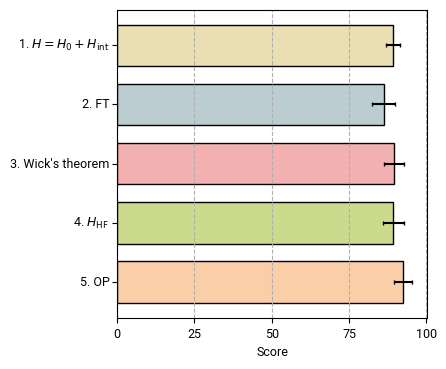

In [47]:
execution_groupby_task_type_mean_score_mean=execution_groupby_task_type_mean_score.loc[task_type_order[::-1]]['mean']
execution_groupby_task_type_mean_score_sem=execution_groupby_task_type_mean_score.loc[task_type_order[::-1]]['sem']
ax=execution_groupby_task_type_mean_score_mean.plot(kind='barh',xerr=execution_groupby_task_type_mean_score_sem,figsize=(4,4),capsize=1.5,edgecolor='k',width=0.7,color=step_color_list[::-1])

ax.set_yticklabels([])
[ax.text(-0.05,idx,str(5-idx)+'. '+task,ha='right',va='center',) for idx,task in enumerate(execution_groupby_task_type_mean_score_mean.index)]


ax.grid(axis='x',ls='--')
ax.set_ylabel('')
ax.set_xlabel('Score')
ax.set_xticks(ticks=np.arange(0,2.1,0.5),labels=['0','25','50','75','100'])
ax.get_figure().savefig('3d.pdf',bbox_inches='tight')

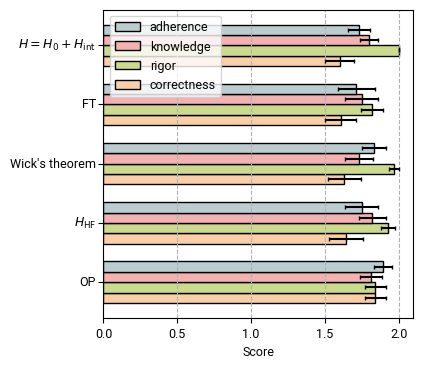

In [55]:
execution_groupby_task_type_mean=execution_groupby_task_type[execution_groupby_task_type[('in paper','count')]>2].loc[task_type_order[::-1]].loc[:,(slice(None),'mean')].iloc[:,:1:-1].droplevel(1,axis=1)
execution_groupby_task_type_sem=execution_groupby_task_type[execution_groupby_task_type[('in paper','count')]>2].loc[task_type_order[::-1]].loc[:,(slice(None),'sem')].iloc[:,:1:-1].droplevel(1,axis=1)
ax=execution_groupby_task_type_mean.plot(kind='barh',xerr=execution_groupby_task_type_sem,figsize=(4,4),color=step_color_list[::-1],capsize=1.5,edgecolor='k',width=0.7,)
ax.grid(axis='x',ls='--')
ax.set_ylabel('')
ax.set_xlabel('Score')
# ax.set_yticklabels(['\n'.join(textwrap.wrap(task, width=20)) for task in execution_groupby_task_type_mean.index],fontsize=7)
ax.set_yticklabels([])
[ax.text(-0.05,idx,task,ha='right',va='center',) for (idx,task) in (enumerate(execution_groupby_task_type_mean.index))]
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1])
# ax.set_title('Score of execution by different steps')

# Score by branch

In [48]:
branch_from_arxiv=dict(zip(reading_data.index.get_level_values(1),reading_data.index.get_level_values(0)))

In [49]:
execution.index=pd.MultiIndex.from_tuples([(branch_from_arxiv[index[0]],)+index for index in execution.index.tolist()],names=['branch','arxiv_number','task_type','task'])

In [50]:
execution_groupby_branch=execution.groupby('branch').agg(['mean','sem','count'])

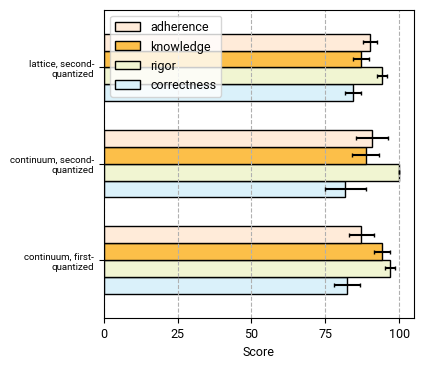

In [62]:
execution_groupby_branch_mean=execution_groupby_branch[execution_groupby_branch[('in paper','count')]>2].loc[:,(slice(None),'mean')].iloc[:,:1:-1].droplevel(1,axis=1)
exeution_groupby_branch_sem=execution_groupby_branch[execution_groupby_branch[('in paper','count')]>2].loc[:,(slice(None),'sem')].iloc[:,:1:-1].droplevel(1,axis=1)
ax=execution_groupby_branch_mean.plot(kind='barh',xerr=exeution_groupby_branch_sem,figsize=(4,4),color=["#daf1fa","#f1f5d2","#fcbf49","#ffebd9"],capsize=1.5,edgecolor='k',width=0.7,)
# '#AA5454','#007895','#55571F','#C37B3B',
# ['#e7ecef','#274c77','#6096ba','#a3cef1']
ax.grid(axis='x',ls='--')
ax.set_ylabel('')
ax.set_xlabel('Score')
ax.set_yticklabels(['\n'.join(textwrap.wrap(task, width=20)) for task in execution_groupby_branch_mean.index],fontsize=7)
# ax.set_title('Score of execution by branches')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1])
ax.set_xticks(ticks=np.arange(0,2.1,0.5),labels=['0','25','50','75','100'])
ax.get_figure().savefig('SM_d.pdf',bbox_inches='tight')

# Score conditioned on in paper

In [52]:
execution_groupby_in_paper=execution.groupby('in paper').agg(['mean','sem','count'])

In [53]:
execution_groupby_in_paper[execution_groupby_in_paper[('correctness','count')]>2].loc[:,(slice(None),'mean')].iloc[::-1,:0:-1]

,correctness,rigor,knowledge,adherence
,mean,mean,mean,mean
in paper,,,,
2,1.649123,1.929825,1.789474,1.771930
1,1.700000,1.925000,1.850000,1.850000
0,1.666667,1.902778,1.750000,1.763889


In [54]:
execution_groupby_in_paper[execution_groupby_in_paper[('correctness','count')]>2].loc[:,(slice(None),'mean')].iloc[::-1,:0:-1]

,correctness,rigor,knowledge,adherence
,mean,mean,mean,mean
in paper,,,,
2,1.649123,1.929825,1.789474,1.771930
1,1.700000,1.925000,1.850000,1.850000
0,1.666667,1.902778,1.750000,1.763889


In [56]:
labels

['2', '1', '0']

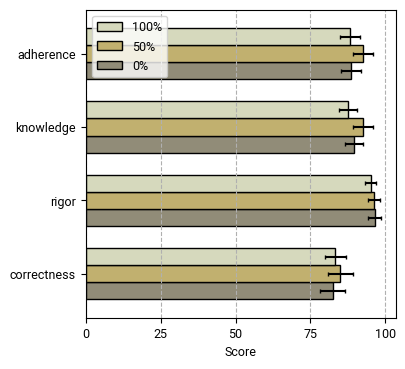

In [57]:
execution_groupby_in_place_mean=execution_groupby_in_paper[execution_groupby_in_paper[('correctness','count')]>2].loc[:,(slice(None),'mean')].iloc[::-1,:0:-1].droplevel(1,axis=1).T
execution_groupby_in_place_sem=execution_groupby_in_paper[execution_groupby_in_paper[('correctness','count')]>2].loc[:,(slice(None),'sem')].iloc[::-1,:0:-1].droplevel(1,axis=1).T
ax=execution_groupby_in_place_mean.plot(kind='barh',xerr=execution_groupby_in_place_sem,figsize=(4,4),color=['#918c78','#c1b06f','#d6d9bd'],capsize=1.5,edgecolor='k',width=0.7,)
ax.grid(axis='x',ls='--')
ax.set_ylabel('')
ax.set_xlabel('Score')
# ax.set_yticklabels(['\n'.join(textwrap.wrap(task.replace(' ',' '), width=20)) for task in execution_groupby_in_place_mean.index],fontsize=7)
ax.legend().set_title('Answer\nOverlap')
# ax.set_title('Overlap between asnwers and training papers')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], ["100%","50%","0%"])
ax.set_xticks(ticks=np.arange(0,2.1,0.5),labels=['0','25','50','75','100'])

ax.get_figure().savefig('3c.pdf',bbox_inches='tight')

In [51]:
execution_groupby_branch_mean

,follow instructions,physics logic,math derivation,final answer accuracy
branch,,,,
"continuum, first-quantized",1.745098,1.882353,1.941176,1.647059
"continuum, second-quantized",1.818182,1.681818,2.000000,1.545455
"lattice, second-quantized",1.804598,1.781609,1.919540,1.701149


# Score conditioned on prompt_quality

In [58]:
execution_groupby_prompt_quality=execution.groupby('prompt quality').agg(['mean','sem','count'])

In [59]:
execution_groupby_prompt_quality[execution_groupby_prompt_quality[('correctness','count')]>=2]

in paper                 adherence                 knowledge  \
                    mean       sem count      mean       sem count      mean   
prompt quality                                                                 
0               2.000000  0.000000     3  1.000000  0.577350     3  1.000000   
1               1.352941  0.170233    17  1.764706  0.136377    17  1.588235   
2               0.838926  0.071309   149  1.805369  0.040041   149  1.825503   

                                   rigor                 correctness  \
                     sem count      mean       sem count        mean   
prompt quality                                                         
0               0.577350     3  1.333333  0.666667     3    0.666667   
1               0.123038    17  2.000000  0.000000    17    1.235294   
2               0.036552   149  1.919463  0.022368   149    1.738255   

                                
                     sem count  
prompt quality                  
0               0.666667     3  
1               0.182495    17  
2               0.041942   149

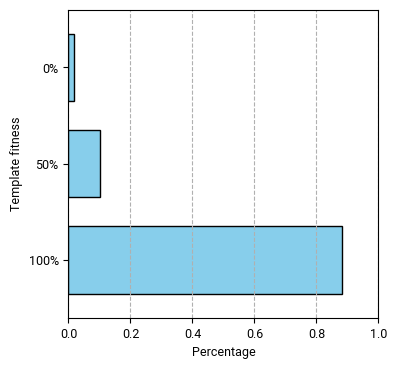

In [69]:
execution_groupby_prompt_quality_percentage=execution_groupby_prompt_quality.loc[:,(slice(None),'count')].iloc[:,0]/execution_groupby_prompt_quality.loc[:,(slice(None),'count')].iloc[:,0].sum()
ax=execution_groupby_prompt_quality_percentage.iloc[::-1].plot(kind='barh',figsize=(4,4),color='skyblue',edgecolor='k',width=0.7,)
ax.set_xlabel('Percentage')
ax.set_ylabel('Template fitness')
ax.grid(axis='x',ls='--')
ax.set_xlim(0,1)
ax.set_yticks(ticks=[0,1,2],labels=["100%","50%","0%"])
ax.get_figure().savefig('SM_b.pdf',bbox_inches='tight')

In [60]:
execution_groupby_prompt_quality

in paper                 adherence                 knowledge  \
                    mean       sem count      mean       sem count      mean   
prompt quality                                                                 
0               2.000000  0.000000     3  1.000000  0.577350     3  1.000000   
1               1.352941  0.170233    17  1.764706  0.136377    17  1.588235   
2               0.838926  0.071309   149  1.805369  0.040041   149  1.825503   

                                   rigor                 correctness  \
                     sem count      mean       sem count        mean   
prompt quality                                                         
0               0.577350     3  1.333333  0.666667     3    0.666667   
1               0.123038    17  2.000000  0.000000    17    1.235294   
2               0.036552   149  1.919463  0.022368   149    1.738255   

                                
                     sem count  
prompt quality                  
0               0.666667     3  
1               0.182495    17  
2               0.041942   149

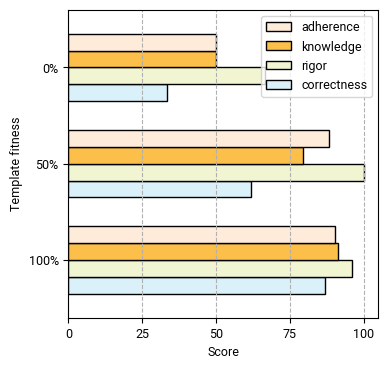

In [70]:
execution_groupby_prompt_quality_mean=execution_groupby_prompt_quality[execution_groupby_prompt_quality[('correctness','count')]>=2].loc[::-1,(slice(None),'mean')].iloc[:,:0:-1].droplevel(1,axis=1)
execution_groupby_prompt_quality_sem=execution_groupby_prompt_quality[execution_groupby_prompt_quality[('correctness','count')]>=2].loc[::-1,(slice(None),'sem')].iloc[:,:0:-1].droplevel(1,axis=1)
ax=execution_groupby_prompt_quality_mean.plot(kind='barh',figsize=(4,4),color=["#daf1fa","#f1f5d2","#fcbf49","#ffebd9"],capsize=1.5,edgecolor='k',width=0.7,)
# ['#AA5454','#007895','#55571F','#C37B3B',]
# ['#e7ecef','#274c77','#6096ba','#a3cef1']
ax.grid(axis='x',ls='--')
ax.set_ylabel('Template fitness')
ax.set_xlabel('Score')
# ax.set_yticklabels(['\n'.join(textwrap.wrap(task.replace(' ',' '), width=20)) for task in execution_groupby_prompt_quality_mean.index],fontsize=7)
# ax.set_yticks(np.arange(4))
# ax.legend().set_title('Template\nFitness')
# ax.set_title('Deviation from standard structure of template')

# for index,value in enumerate(execution_groupby_prompt_quality[('in paper','count')]):
# # for yval,(xval,val) in enumerate(zip(execution_groupby_prompt_quality[('in paper','count')],))
#     for idx in range(4):
#         ax.text(0.2, idx+(index-1)*0.7/3, str(value), color='black', va='center')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1])
ax.set_xticks(ticks=np.arange(0,2.1,0.5),labels=['0','25','50','75','100'])
ax.set_yticks(ticks=[0,1,2],labels=["100%","50%","0%"])
ax.get_figure().savefig('SM_c.pdf',bbox_inches='tight')

In [70]:
execution_groupby_branch_mean

,correctness,rigor,knowledge,adherence
branch,,,,
"continuum, first-quantized",1.647059,1.941176,1.882353,1.745098
"continuum, second-quantized",1.636364,2.000000,1.772727,1.818182
"lattice, second-quantized",1.687500,1.885417,1.739583,1.802083


# Obsolete

Text(0.5, 0, 'Score')

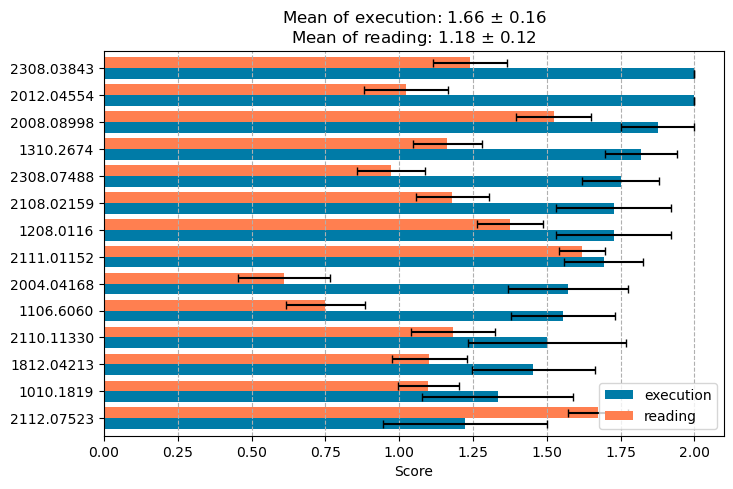

In [ ]:
execution_reading_mean=pd.concat([arxiv_dict_mean,reading_data_mean],axis=1,).rename(columns={'final answer accuracy':'execution','Value':'Extraction'}).sort_values('execution')
execution_reading_se=pd.concat([arxiv_dict_se,reading_data_se],axis=1,).rename(columns={'final answer accuracy':'execution','Value':'Extraction'}).sort_values('execution')

execution_reading_mean.plot(kind='barh',color=['#007BA7', '#FF7F50'],figsize=(8,5),width=0.8,xerr=execution_reading_se,capsize=3)
plt.title('\n'.join([f'Mean of {kind}: {mean:.2f} $\pm$ {se:.2f}' for kind,mean,se in zip(['Execution','Extraction'],execution_reading_mean.mean(),execution_reading_se.mean())]))
plt.grid(axis='x',ls='--')
plt.xlabel('Score')

In [ ]:
color_list=[plt.cm.Blues(0.2+0.8*(i/6)) for i in range(6,0,-1)]

Text(0.5, 0, 'Score')

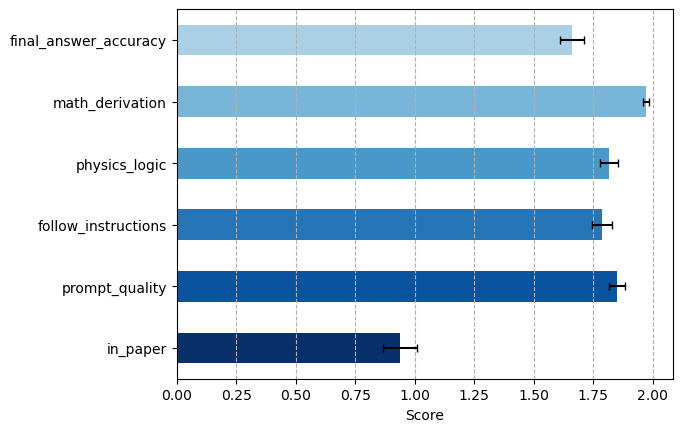

In [ ]:
arxiv_dict.mean().plot(kind='barh',color=[plt.cm.Blues(0.2+0.8*(i/6)) for i in range(6,0,-1)],xerr=arxiv_dict.sem(),capsize=3,)
plt.grid(axis='x',ls='--')
plt.xlabel('Score')

In [ ]:
import pandas as pd

In [ ]:
def load_score(arxiv_number):
    prompt_template='../prompt_template.md'
    # arxiv_number='1106.6060'
    prompt_dict=load_prompt_template(prompt_template)
    with open(os.path.join('..',f'{arxiv_number}',f'{arxiv_number}.yaml'),'r') as f:
        kwargs= yaml.safe_load(f)
    tasks=[f'Task:{idx} '+kwarg['task'] for idx,kwarg in enumerate(kwargs[1:])]
    aspect_score={}
    for kwarg in kwargs[1:]:
        for key,value in (list(kwarg['score'].items())):
            if key not in aspect_score:
                aspect_score[key]=[value]
            else:
                aspect_score[key].append(value)
    return pd.DataFrame(aspect_score,index=tasks)

In [ ]:
df_list=[load_score(arxiv_number) for arxiv_number in arxiv_number_list]

In [ ]:
dfs=pd.concat(df_list,keys=arxiv_number_list,names=['arxiv_number','task'])

In [ ]:
dfs

NameError: name 'dfs' is not defined

Text(0.5, 0, 'Score')

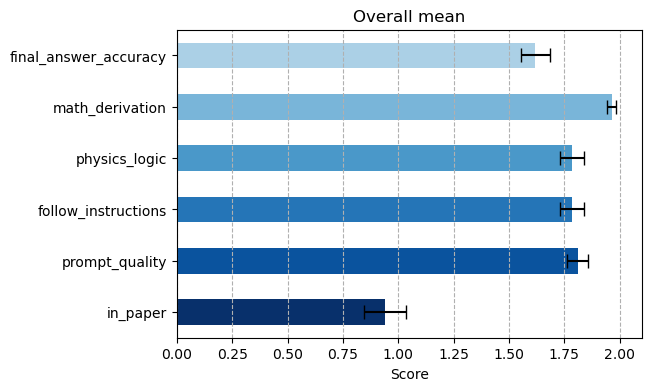

In [ ]:
error_bar=dfs.std().values/dfs.shape[0]**0.5
dfs.mean().plot(kind='barh',figsize=(6,4),xlim=(0,2.1),title='Overall mean',color=color_list,xerr=error_bar,capsize=5)
plt.grid(axis='x',ls='--')
plt.xlabel('Score')

In [ ]:
df.T

,Original Score,Conditional Score
Quality,8,7
Efficiency,6,5
Reliability,7,8
Innovation,9,8


In [ ]:
group='in_paper'
# group='prompt_quality'
mean=arxiv_dict.groupby(group)[['follow_instructions','physics_logic','math_derivation','final answer accuracy']].mean()
error_bar=arxiv_dict.groupby(group)[['follow_instructions','physics_logic','math_derivation','final answer accuracy']].std()/arxiv_dict.groupby(group)[['follow_instructions','physics_logic','math_derivation','final answer accuracy']].count()**0.5


In [ ]:
mean

,follow_instructions,physics_logic,math_derivation,final_answer_accuracy
in_paper,,,,
0,1.727273,1.781818,2.000000,1.672727
1,1.850000,1.850000,1.925000,1.725000
2,1.804348,1.826087,1.978261,1.586957


In [ ]:
list(mean.iterrows())

[(0,
  follow_instructions      1.727273
  physics_logic            1.781818
  math_derivation          2.000000
  final_answer_accuracy    1.672727
  Name: 0, dtype: float64),
 (1,
  follow_instructions      1.850
  physics_logic            1.850
  math_derivation          1.925
  final_answer_accuracy    1.725
  Name: 1, dtype: float64),
 (2,
  follow_instructions      1.804348
  physics_logic            1.826087
  math_derivation          1.978261
  final_answer_accuracy    1.586957
  Name: 2, dtype: float64)]

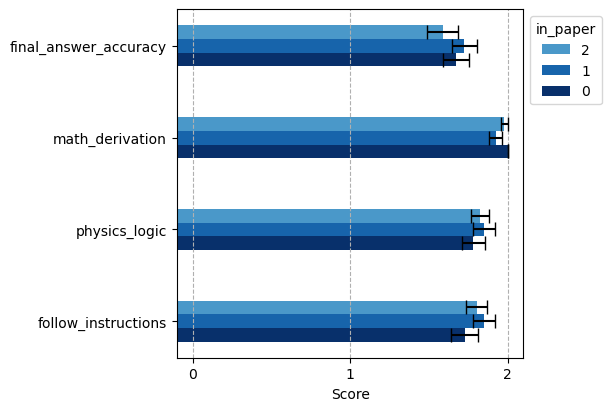

In [ ]:
x = np.arange(mean.shape[1])  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained',figsize=(6,4))
color_list=[plt.cm.Blues(0.2+0.8*(i/4)) for i in range(4,0,-1)]
# for attribute, measurement in aspect_score.items():
for attribute, measurement in mean.iterrows():
    offset = width * multiplier
    if not error_bar.loc[attribute].isna().any():
        rects = ax.barh(x + offset, np.array(measurement)+0.1, width, label=attribute,color=color_list[multiplier],left=-0.1,xerr=error_bar.loc[attribute].values,capsize=5)
    # ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_xlabel('Score')
ax.set_xticks([0,1,2])
# ax.set_title(f"{arxiv_number}")
ax.set_yticks(x + width*1, ['\n'.join(textwrap.wrap(label, width=40)) for label in mean.columns])

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1],loc='upper left', ncols=1,bbox_to_anchor=(1, 1),title=group)

ax.grid(axis='x',ls='--')
# ax.set_ylim(0, 250)
ax.set_xlim(-0.1,2.1)

plt.show()

# Font

In [1]:
import matplotlib.font_manager as font_manager


In [2]:
fonts = sorted(set([f.name for f in font_manager.fontManager.ttflist]))


In [3]:
fonts

['DejaVu Sans',
 'DejaVu Sans Display',
 'DejaVu Sans Mono',
 'DejaVu Serif',
 'DejaVu Serif Display',
 'Roboto',
 'STIXGeneral',
 'STIXNonUnicode',
 'STIXSizeFiveSym',
 'STIXSizeFourSym',
 'STIXSizeOneSym',
 'STIXSizeThreeSym',
 'STIXSizeTwoSym',
 'Ubuntu',
 'Ubuntu Condensed',
 'Ubuntu Mono',
 'cmb10',
 'cmex10',
 'cmmi10',
 'cmr10',
 'cmss10',
 'cmsy10',
 'cmtt10']

In [8]:
from matplotlib.font_manager import FontProperties


In [13]:
roboto_font = FontProperties(fname='/home/jake/.fonts/Roboto-Regular.ttf')


In [14]:
roboto_font

In [78]:
%reload_ext matplotlib

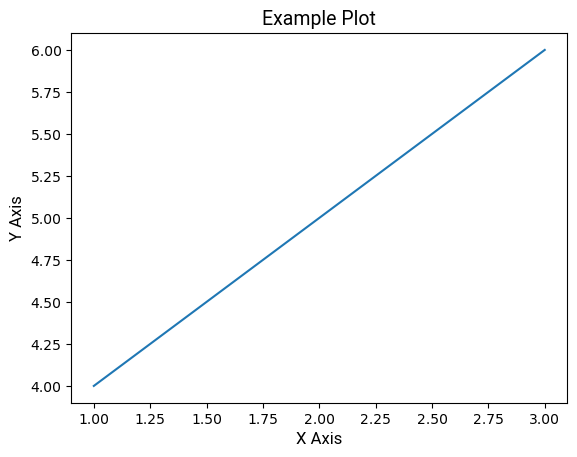

In [4]:
import matplotlib.pyplot as plt

# Example plot
plt.plot([1, 2, 3], [4, 5, 6])

# Using Roboto font for title and labels
plt.title('Example Plot', fontname='Roboto', fontsize=14)
plt.xlabel('X Axis', fontname='Roboto', fontsize=12)
plt.ylabel('Y Axis', fontname='Roboto', fontsize=12)

plt.show()


In [16]:
matplotlib.__version__

'3.7.1'

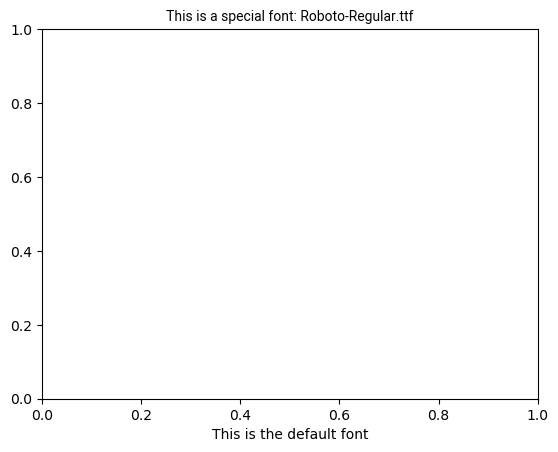

In [20]:
from pathlib import Path

import matplotlib.pyplot as plt

import matplotlib as mpl

fig, ax = plt.subplots()


ax.set_title(f'This is a special font: {fpath.name}', font=fpath)
ax.set_xlabel('This is the default font')

plt.show()